In [35]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t

In [36]:
# Load datasets
df = pd.read_csv("C:\\YEAR1\\NMVOC\\Data\\processed_c3h8.csv", parse_dates=['datetime'])
df

,datetime,C3H8_ppb
0,2011-01-05 00:00:00,0.70974
1,2011-01-05 02:00:00,0.78550
2,2011-01-05 04:00:00,0.72628
3,2011-01-05 06:00:00,0.94738
4,2011-01-05 08:00:00,0.74331
...,...,...
41494,2023-12-31 02:00:00,0.07656
41495,2023-12-31 04:00:00,0.11815
41496,2023-12-31 05:00:00,0.10664
41497,2023-12-31 07:00:00,0.10012


In [37]:
# helper columns with  hour, month, year
#df['hour'] = df['starttime_dt'].dt.hour
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['date'] = df['datetime'].dt.date
df['day_m'] = df['datetime'].dt.day
df['day'] = df['datetime'].dt.dayofyear
df["hour"] = df['datetime'].dt.hour
df

,datetime,C3H8_ppb,month,year,date,day_m,day,hour
0,2011-01-05 00:00:00,0.70974,1,2011,2011-01-05,5,5,0
1,2011-01-05 02:00:00,0.78550,1,2011,2011-01-05,5,5,2
2,2011-01-05 04:00:00,0.72628,1,2011,2011-01-05,5,5,4
3,2011-01-05 06:00:00,0.94738,1,2011,2011-01-05,5,5,6
4,2011-01-05 08:00:00,0.74331,1,2011,2011-01-05,5,5,8
...,...,...,...,...,...,...,...,...
41494,2023-12-31 02:00:00,0.07656,12,2023,2023-12-31,31,365,2
41495,2023-12-31 04:00:00,0.11815,12,2023,2023-12-31,31,365,4
41496,2023-12-31 05:00:00,0.10664,12,2023,2023-12-31,31,365,5
41497,2023-12-31 07:00:00,0.10012,12,2023,2023-12-31,31,365,7


In [38]:

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Add season (DJF, MAM, JJA, SON)

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

In [ ]:
#Diel variation in C3H8 concentration

# Extract hour from datetime
#df["hour"] = df["starttime_dt"].dt.hour

# Group by hour and calculate statistics
grouped = df.groupby("hour")["C3H8_ppb"]
means = grouped.mean()
stds = grouped.std()
counts = grouped.count()

# Calculate 95% confidence interval
confidence = 0.95
t_value = t.ppf((1 + confidence) / 2, df=counts - 1)  # t critical value
margin_of_error = t_value * (stds / np.sqrt(counts))

lower_bound = means - margin_of_error
upper_bound = means + margin_of_error

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(means.index, means, label="Hourly Mean", color="blue", marker='o')
plt.fill_between(means.index, lower_bound, upper_bound, color="blue", alpha=0.2, label="95% CI")
plt.title("Hourly Means with 95% Confidence Interval, no smoothing")
plt.xlabel("Hour of Day")
plt.ylabel("$C_3H_8$ [ppb]")
plt.xticks(range(24))
plt.ylim(0.1, 0.7)
plt.legend()
plt.grid()
#plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_diel.png", dpi=300)
plt.show()

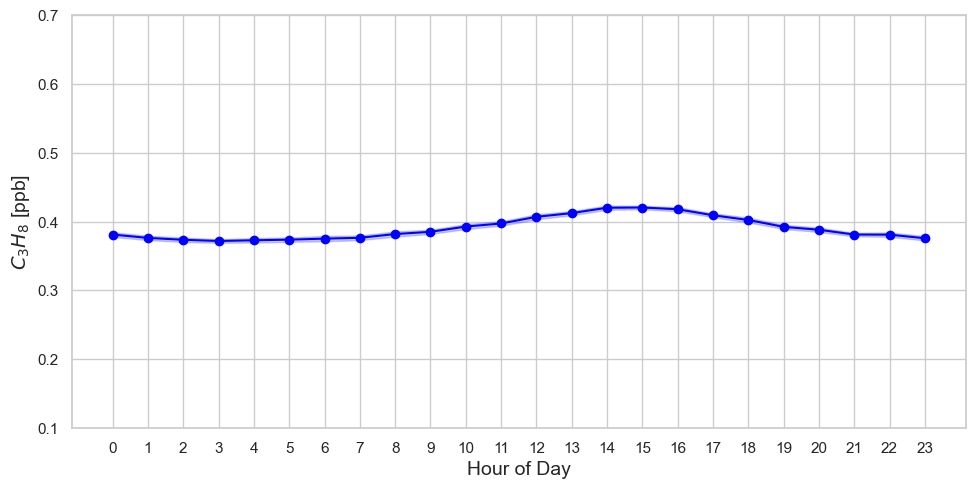

In [39]:
# Diel variation in C3H8 concentration
# --- Step 1: Preprocess ---
#grouped = df.groupby(['year', 'hour'])['C3H8_ppb']
# 3-hour centered moving average

# --- Step 2: Compute hourly means for each year ---
ann_grouped = df.groupby(['year', 'hour'])['C3H8_ppb']
ann_summary = ann_grouped.agg(['mean', sem]).reset_index()
ann_summary.rename(columns={'mean': 'avg', 'sem': 'sem'}, inplace=True)

# --- Step 3: Average across all years for each hour ---
annual_diel = ann_summary.groupby('hour').agg({'avg': 'mean', 'sem': lambda x: sem(x, nan_policy='omit')}).reset_index()

# --- Step 4: Apply 3-hour centered moving average ---
annual_diel['avg_smooth'] = annual_diel['avg'].rolling(window=3, center=True, min_periods=1).mean()
annual_diel['sem_smooth'] = annual_diel['sem'].rolling(window=3, center=True, min_periods=1).mean()

# --- Step 5: Calculate 95% confidence interval ---
annual_diel['lower'] = annual_diel['avg_smooth'] - 1.96 * annual_diel['sem_smooth']
annual_diel['upper'] = annual_diel['avg_smooth'] + 1.96 * annual_diel['sem_smooth']

# --- Step 6: Plot ---
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid')

plt.plot(annual_diel['hour'], annual_diel['avg_smooth'], label='Annual Avg (Smoothed)', color='blue', marker='o')
plt.fill_between(annual_diel['hour'], annual_diel['lower'], annual_diel['upper'], alpha=0.2, color='blue')

#plt.title('Annually Averaged Diel Variation of C3H8_ppb\n(Smoothed, 3-Hour Window)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('$C_3H_8$ [ppb]', fontsize=14)
plt.xticks(range(0, 24))
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=False)
plt.tight_layout()
plt.ylim(0.1, 0.7)
#plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_Annual_diel_3h_smooth.png", dpi=300)
plt.show()

In [ ]:
# #diel variation per seasons, 1 plot
# Define seasons by month
season_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
}

# Function to calculate hourly stats for a specific season
def get_hourly_stats(data):
    grouped = data.groupby("hour")["C3H8_ppb"]
    means = grouped.mean()
    stds = grouped.std()
    counts = grouped.count()

    # Calculate 95% confidence interval
    confidence = 0.95
    t_value = t.ppf((1 + confidence) / 2, df=counts - 1)  # t critical value
    margin_of_error = t_value * (stds / np.sqrt(counts))

    lower_bound = means - margin_of_error
    upper_bound = means + margin_of_error

    return means, lower_bound, upper_bound

# Initialize plot
plt.figure(figsize=(8, 6))
colors = {"Winter": "blue", "Spring": "green", "Summer": "orange", "Autumn": "red"}

# Loop through seasons and plot
for season, months in season_months.items():
    # Filter data for the current season
    season_data = df[df["month"].isin(months)]
    
    # Calculate hourly stats
    means, lower, upper = get_hourly_stats(season_data)
    
    # Plot
    plt.plot(means.index, means, label=f"{season} Mean", color=colors[season], marker='o')
    plt.fill_between(means.index, lower, upper, color=colors[season], alpha=0.2, label=f"{season} 95% CI")

# Customize the plot
plt.title("Hourly Means with 95% Confidence Interval for Seasons (2011–2023), no smoothing")
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("$C_3H_8$ [ppt]", fontsize=14)
plt.xticks(range(24))
plt.legend(loc='best', title="",
            ncol=4, columnspacing=3, bbox_to_anchor=(1, -0.12), frameon=False)
plt.grid()
plt.tight_layout()
# Show plot

plt.show()

In [40]:
# percentage difference for not smoothed
# Define seasons by month
season_months = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
}

# Function to calculate hourly stats for a specific season
def get_hourly_stats(data):
    grouped = data.groupby("hour")["C3H8_ppb"]
    means = grouped.mean()
    return means

# Calculate hourly stats and percentage difference for each season
results = []

for season, months in season_months.items():
    # Filter data for the current season
    season_data = df[df["month"].isin(months)]
    
    # Calculate hourly stats
    means = get_hourly_stats(season_data)
    
    # Find the maximum value and corresponding hour
    max_value = means.max()
    max_hour = means.idxmax()
    
    # Store the mean values of all hours for the season
    season_mean = means.mean()  # Average of hourly means for the season
    
    # Calculate percentage difference for all hours
    for hour, mean_value in means.items():
        percentage_of_max = (mean_value / max_value) * 100
        difference_from_max = 100 - percentage_of_max
        results.append({
            "Season": season,
            "Hour": hour,
            "Mean Value": mean_value,
            "% of Max": percentage_of_max,
            "Difference from Max (%)": difference_from_max,
            "Season Hourly Mean": season_mean
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
pd.set_option('display.float_format', '{:.2f}'.format)  # Format for better readability
print(results_df)


    Season  Hour  Mean Value  % of Max  Difference from Max (%)  \
0   Winter     0        0.63     96.86                     3.14   
1   Winter     1        0.64     97.33                     2.67   
2   Winter     2        0.62     94.52                     5.48   
3   Winter     3        0.62     95.02                     4.98   
4   Winter     4        0.63     96.03                     3.97   
..     ...   ...         ...       ...                      ...   
91  Autumn    19        0.29     83.13                    16.87   
92  Autumn    20        0.31     90.31                     9.69   
93  Autumn    21        0.28     81.14                    18.86   
94  Autumn    22        0.31     89.67                    10.33   
95  Autumn    23        0.28     79.40                    20.60   

    Season Hourly Mean  
0                 0.63  
1                 0.63  
2                 0.63  
3                 0.63  
4                 0.63  
..                 ...  
91                0.

In [ ]:

#To plot diel (daily) variation of a variable like C3H8_ppb for the 4 seasons in a single plot — including:

#A moving average,  95% confidence interval (CI), Seasonally split data
#Ismoothing: a 3-hour centered moving average. That means:For each hour (e.g., 10 AM), the smoothed value is 
# the average of that hour and the two adjacent hours — one before and one after (e.g., 9 AM, 10 AM, and 11 AM).



# Group by season and hour
grouped = df.groupby(['season', 'hour'])['C3H8_ppb']

# Compute mean and SEM
summary = grouped.agg(['mean', sem]).reset_index()
summary.rename(columns={'mean': 'avg', 'sem': 'sem'}, inplace=True)

# Smooth with 3-hour centered moving average
def smooth_series(s):
    return s.rolling(window=3, center=True, min_periods=1).mean()

smoothed = []
for season in summary['season'].unique():
    temp = summary[summary['season'] == season].copy()
    temp.sort_values('hour', inplace=True)
    temp['avg_smooth'] = smooth_series(temp['avg'])
    temp['sem_smooth'] = smooth_series(temp['sem'])
    temp['lower'] = temp['avg_smooth'] - 1.96 * temp['sem_smooth']
    temp['upper'] = temp['avg_smooth'] + 1.96 * temp['sem_smooth']
    smoothed.append(temp)

summary_smooth = pd.concat(smoothed)

# Plot
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')

for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    data = summary_smooth[summary_smooth['season'] == season]
    plt.plot(data['hour'], data['avg_smooth'], label=season, marker='o')
    plt.fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)

#plt.title('Diel Variation of C3H8_ppb by Season (Smoothed, 3-Hour Window)')
plt.xlabel('Hour of Day')
plt.ylabel('$C_3H_8$  [ppb]')
plt.xticks(range(0, 24))
plt.legend(title='Season')
plt.tight_layout()
plt.ylim(0.1, 0.7)
plt.legend(
    title='Legend',
    loc='upper right',
    bbox_to_anchor=(0.9, 0.75),  # adjust vertical offset as needed
    ncol=2,                      # all 4 seasons in one row
    frameon=False
)
#plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_diel_seas_3h.png", dpi=300)
plt.show()


In [41]:
### 1/3) two-panel figure in a single row with subplots labeled as (a) and (b)
#  
#  Diel variation in C3H8 concentration

# --- Step 2: Compute hourly means for each year ---
ann_grouped = df.groupby(['year', 'hour'])['C3H8_ppb']
ann_summary = ann_grouped.agg(['mean', sem]).reset_index()
ann_summary.rename(columns={'mean': 'avg', 'sem': 'sem'}, inplace=True)

# --- Step 3: Average across all years for each hour ---
annual_diel = ann_summary.groupby('hour').agg({'avg': 'mean', 'sem': lambda x: sem(x, nan_policy='omit')}).reset_index()

# --- Step 4: Apply 3-hour centered moving average ---
annual_diel['avg_smooth'] = annual_diel['avg'].rolling(window=3, center=True, min_periods=1).mean()
annual_diel['sem_smooth'] = annual_diel['sem'].rolling(window=3, center=True, min_periods=1).mean()

# --- Step 5: Calculate 95% confidence interval ---
annual_diel['lower'] = annual_diel['avg_smooth'] - 1.96 * annual_diel['sem_smooth']
annual_diel['upper'] = annual_diel['avg_smooth'] + 1.96 * annual_diel['sem_smooth']


In [15]:
### 2/3) two-panel figure in a single row with subplots labeled as (a) and (b) 

#To plot diel (daily) variation of a variable like C3H8_ppb for the 4 seasons in a single plot — including:
#  Group by season and hour
seas_grouped = df.groupby(['season', 'hour'])['C3H8_ppb']

# Compute mean and SEM
seas_summary = seas_grouped.agg(['mean', sem]).reset_index()
seas_summary.rename(columns={'mean': 'avg', 'sem': 'sem'}, inplace=True)

# Smooth with 3-hour centered moving average
def smooth_series(s):
    return s.rolling(window=3, center=True, min_periods=1).mean()

smoothed = []
for season in seas_summary['season'].unique():
    temp = seas_summary[seas_summary['season'] == season].copy()
    temp.sort_values('hour', inplace=True)
    temp['avg_smooth'] = smooth_series(temp['avg'])
    temp['sem_smooth'] = smooth_series(temp['sem'])
    temp['lower'] = temp['avg_smooth'] - 1.96 * temp['sem_smooth']
    temp['upper'] = temp['avg_smooth'] + 1.96 * temp['sem_smooth']
    smoothed.append(temp)

summary_smooth = pd.concat(smoothed)


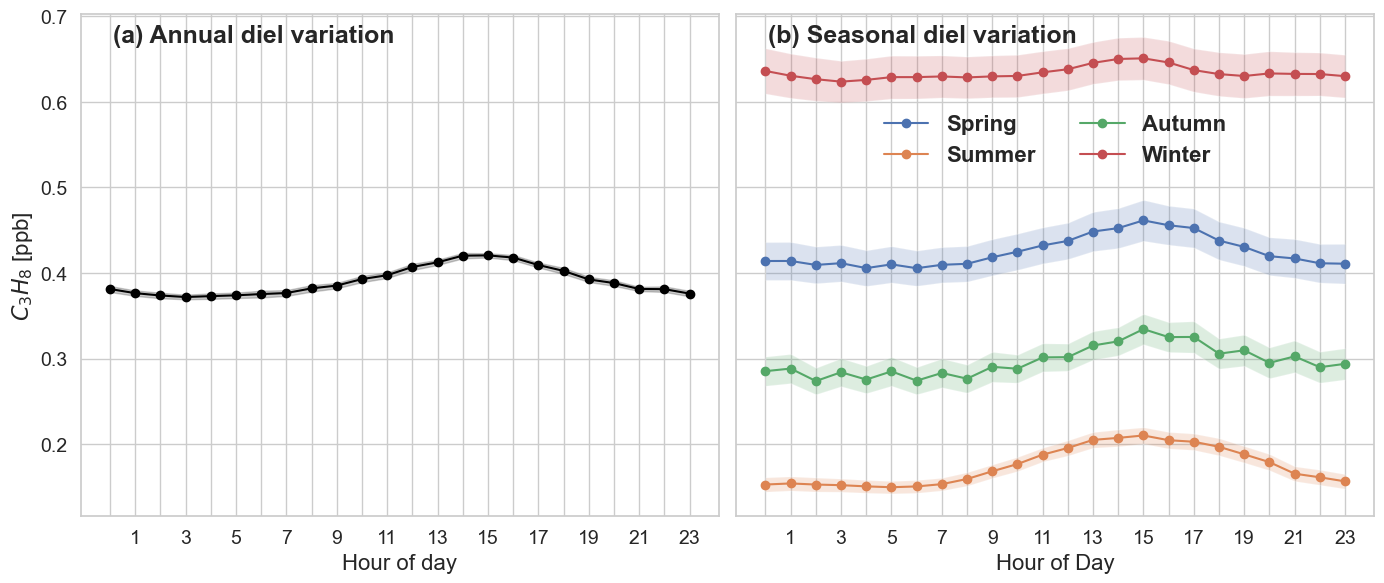

In [34]:
# 3/3) two-panel figure in a single row with subplots labeled as (a) and (b), 

# Create figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.set(style='whitegrid')



# ---- Panel a: Annual average variation ----
axes[0].plot(annual_diel['hour'], annual_diel['avg_smooth'], label='Annual Avg (Smoothed)', color='black', marker='o')
axes[0].fill_between(annual_diel['hour'], annual_diel['lower'], annual_diel['upper'], alpha=0.2, color='black')

axes[0].set_xlabel('Hour of day', fontsize=16)
axes[0].set_ylabel('$C_3H_8$ [ppb]', fontsize=16)
#axes[0].set_title('(a) Annual diel variation', loc='left', fontsize=16)
axes[0].set_xticks(range(0, 24))
axes[0].tick_params(axis='both', labelsize=14)
axes[0].set_xticklabels([str(x) if x % 2 != 0 else "" for x in range(24)])
# Add label inside the panel (e.g., top left corner)
axes[0].text(0.05, 0.98, '(a) Annual diel variation', transform=axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

#axes[0].legend(title='', frameon=False,ncol=2,prop={'size': 14, 'weight': 'bold'}, bbox_to_anchor=(0.5, 0.84))

# ---- Panel b: Seasonal variation ----
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    data = summary_smooth[summary_smooth['season'] == season]
    axes[1].plot(data['hour'], data['avg_smooth'], label=season, marker='o')
    axes[1].fill_between(data['hour'], data['lower'], data['upper'], alpha=0.2)

axes[1].set_xlabel('Hour of Day', fontsize=16)
axes[1].set_xticks(range(0, 24))
#axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xticks(range(0, 24))
#axes[1].tick_params(axis='x', direction='out', length=18, width=3)
axes[1].set_xticklabels([str(x) if x % 2 != 0 else "" for x in range(24)])
axes[1].tick_params(axis='both', labelsize=14)
#axes[1].set_title('(b) Seasonal diel variation', loc='left', fontsize=16)
axes[1].legend(title='', frameon=False,ncol=2,prop={'size': 16, 'weight': 'bold'}, bbox_to_anchor=(0.8, 0.84))
# Add label inside the panel (e.g., top left corner)
axes[1].text(0.05, 0.98, '(b) Seasonal diel variation', transform=axes[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
# Adjust layout
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_diel_annual_seas_3h.png", dpi=300)
plt.show()


In [ ]:
# Save the summary DataFrame to CSV
summary_smooth[['season', 'hour', 'avg_smooth', 'lower', 'upper']].round(3).to_csv('diel_variation_3hsmooth.csv', index=False)


In [ ]:
#Calculate percentage differences from maximum
#  Copy to avoid modifying original
df_percent = summary_smooth.copy()

# Compute percentage difference from max per season
df_percent['max_per_season'] = df_percent.groupby('season')['avg_smooth'].transform('max')
# Calculate percentage difference from max
df_percent['pct_from_max'] = 100 * (df_percent['avg_smooth'] - df_percent['max_per_season']) / df_percent['max_per_season']


df_percent.round(3).to_csv("C:\\YEAR1\\NMVOC\\figures\\c3h8_diel_variation_pct_from_max.csv", index=False)




In [ ]:
annual_diel['avg_smooth'].round(4)